# **LendingClub Loan Default Prediction Project**

## **1. Introduction**


LendingClub is a peer-to-peer (P2P) lending platform where individual investors fund personal loans.  
This project uses the publicly available LendingClub loan dataset (2007–2018) to perform **loan status classification** (Fully Paid vs Charged Off).

Because the dataset contains many features and the relationship between borrower characteristics and loan outcomes is nonlinear, linear models such as logistic regression are not expected to perform well. This motivates the use of nonlinear machine‑learning and deep‑learning methods.

Data Source: https://www.kaggle.com/datasets/wordsforthewise/lending-club?utm_source=chatgpt.com&select=accepted_2007_to_2018Q4.csv.gz


## **2. Motivation**

The high-dimensional structure of the dataset makes linear models inadequate, as they cannot capture nonlinear interactions among financial variables.  
Therefore, nonlinear classical machine‑learning models—such as **XGBoost** and **LightGBM**—are more suitable as baseline methods.

For deep learning, we consider two approaches:
- a neural network using **learnable embeddings**, which provide compact representations
- DNN using which fit to table

This setup allows us to examine whether embedding-based representations offer practical advantages on high‑dimensional tabular data.

## **3. Exploratory Data Analysis (EDA)**

Before conducting deeper analysis, the goal is to clean the dataset enough to confirm feasibility of the modeling pipeline.
1. **Missing-value inspection**  
   - Compute missing ratios for all features  
   - Remove columns with more than 30% missing values
   - Filling in Missing data: for numeric data it will be 0, and for categorical data it will be 'Missing'

2. **Removal of non-informative features**  
   - Columns containing only a single unique value  
   - Post-loan or internal LendingClub variables not available at prediction time

3. **Target variable structure**  
   - Check the distribution of `loan_status`  
   - Identify relevant categories for binary classification
   - Check claass imbalance

### **Necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### **3.1 Overview of Dataset Structure**

In [2]:
loan_data = pd.read_csv("loandata.csv")
print(loan_data.head())

C:\Users\Sehong\AppData\Local\Temp\ipykernel_25520\1201518590.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv("loandata.csv")


         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_last_payment_amount disbursement_

### **3.2 Missing-value Inspection**

In [3]:
missing_ratio = loan_data.isnull().mean().sort_values(ascending = False)
print(missing_ratio)

member_id                                     1.000000
orig_projected_additional_accrued_interest    0.996173
hardship_end_date                             0.995171
hardship_start_date                           0.995171
hardship_type                                 0.995171
                                                ...   
policy_code                                   0.000015
revol_bal                                     0.000015
fico_range_high                               0.000015
fico_range_low                                0.000015
id                                            0.000000
Length: 151, dtype: float64


#### **3.2.1 Remove Features with Excessive Missingness**

In [4]:
threshold =0.3
drop_cols = missing_ratio[missing_ratio > threshold].index.tolist()
print(drop_cols)
loan_data_cleaned = loan_data.drop(columns = drop_cols)
missing_ratio_cleaned = loan_data_cleaned.isnull().mean().sort_values(ascending = False)
print(missing_ratio_cleaned)

['member_id', 'orig_projected_additional_accrued_interest', 'hardship_end_date', 'hardship_start_date', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_last_payment_amount', 'hardship_payoff_balance_amount', 'hardship_loan_status', 'hardship_dpd', 'hardship_length', 'payment_plan_start_date', 'hardship_amount', 'settlement_term', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'revol_bal_joint', 'sec_app_mort_acc', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'mths_since_rec

#### **3.2.2Removal of Non-Informative Features**

In [5]:
const_cols =[c for c in  loan_data_cleaned.columns if loan_data_cleaned[c].nunique() <= 1]
loan_data_cleaned = loan_data_cleaned.drop(columns = const_cols)

#### **3.2.3. Removal of Post-Loan or Internal Variables**

In [6]:
drop_cols = [
    # ID / internal information, has similar information
    "id", "emp_title", "url", "title", "zip_code", "sub_grade", "funded_amnt", "funded_amnt_inv",
    "pymnt_plan", "hardship_flag", "disbursement_method", "debt_settlement_flag",
    # post-loan information
    "out_prncp", "out_prncp_inv",
    "total_pymnt", "total_pymnt_inv",
    "total_rec_prncp","total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt",
    "last_credit_pull_d",
    "last_fico_range_high", "last_fico_range_low",
]

drop_cols = [c for c in drop_cols if c in loan_data_cleaned.columns]
loan_data_cleaned = loan_data_cleaned.drop(columns=drop_cols)
print(loan_data_cleaned.head())

   loan_amnt        term  int_rate  installment grade emp_length  \
0     3600.0   36 months     13.99       123.03     C  10+ years   
1    24700.0   36 months     11.99       820.28     C  10+ years   
2    20000.0   60 months     10.78       432.66     B  10+ years   
3    35000.0   60 months     14.85       829.90     C  10+ years   
4    10400.0   60 months     22.45       289.91     F    3 years   

  home_ownership  annual_inc verification_status   issue_d  ...  \
0       MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1       MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2       MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
3       MORTGAGE    110000.0     Source Verified  Dec-2015  ...   
4       MORTGAGE    104433.0     Source Verified  Dec-2015  ...   

  num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75  \
0                0.0                3.0           76.9               0.0   
1                0.0                

### Critical Data Preprocessing: Preventing Data Leakage

During the feature selection process, we identified several variables (e.g., `recoveries`, `total_rec_prncp`, `total_pymnt`) that contain **post-loan information**. These features represent future events unavailable at the time of loan application (prediction time).

* **Impact of Leakage:** Including these features leads to an unrealistically high performance (**AUC > 0.98**), which is a clear sign of data leakage (overfitting to future data).
* **Decision:** To ensure the validity and robustness of our model for real-world credit scoring, **we have strictly removed these features** from the training dataset.

> **Reference:** For a detailed experiment validating this data leakage (including AUC comparison and Feature Importance analysis), please refer to the supplementary notebook: **`Appendix_Data_Leakage_Analysis.ipynb`**

#### **3.2.5 Dealing with some categorical features**

In [7]:
emp_map ={
     '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
        '10+ years': 10
}
loan_data_cleaned['emp_length'] = loan_data_cleaned['emp_length'].map(emp_map).fillna(-1)

if loan_data_cleaned['term'].dtype == 'object':
    loan_data_cleaned['term'] = loan_data_cleaned['term'].str.extract('(\d+)').astype(float)

#### **3.2.4. Filling in missing data**

In [8]:
num_cols = loan_data_cleaned.select_dtypes(include =['int','float']).columns.tolist()
print(num_cols)
loan_data_cleaned[num_cols] = loan_data_cleaned[num_cols].fillna(0)
loan_data_cleaned[num_cols].isna().sum().sort_values(ascending =False)

['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']


loan_amnt                     0
term                          0
mo_sin_rcnt_tl                0
mort_acc                      0
mths_since_recent_bc          0
mths_since_recent_inq         0
num_accts_ever_120_pd         0
num_actv_bc_tl                0
num_actv_rev_tl               0
num_bc_sats                   0
num_bc_tl                     0
num_il_tl                     0
num_op_rev_tl                 0
num_rev_accts                 0
num_rev_tl_bal_gt_0           0
num_sats                      0
num_tl_120dpd_2m              0
num_tl_30dpd                  0
num_tl_90g_dpd_24m            0
num_tl_op_past_12m            0
pct_tl_nvr_dlq                0
percent_bc_gt_75              0
pub_rec_bankruptcies          0
tax_liens                     0
tot_hi_cred_lim               0
total_bal_ex_mort             0
total_bc_limit                0
mo_sin_rcnt_rev_tl_op         0
mo_sin_old_rev_tl_op          0
mo_sin_old_il_acct            0
revol_bal                     0
int_rate

In [9]:
loan_data_cleaned = loan_data_cleaned.fillna('Missing')
loan_data_cleaned.isna().sum().sort_values()

loan_amnt                     0
chargeoff_within_12_mths      0
delinq_amnt                   0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
                             ..
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
fico_range_low                0
total_il_high_credit_limit    0
Length: 66, dtype: int64

### **3.3.Target variable structure**

In [10]:
loan_data_cleaned['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Missing                                                     33
Name: count, dtype: int64

We need to remove ``Current`` and ``Missing`` status

In [11]:
df = loan_data_cleaned.copy()
undetermined_status = ['Missing', 'Current']
loan_data_cleaned = df[~df['loan_status'].isin(undetermined_status)]
loan_data_cleaned['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [12]:
bad_status = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Late (16-30 days)"
    "Does not meet the credit policy. Status:Charged Off"
]

loan_data_cleaned['target'] = loan_data_cleaned['loan_status'].isin(bad_status).astype(int)

loan_data_cleaned['target'].value_counts()

C:\Users\Sehong\AppData\Local\Temp\ipykernel_25520\2949952140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_cleaned['target'] = loan_data_cleaned['loan_status'].isin(bad_status).astype(int)


target
0    1092285
1     290066
Name: count, dtype: int64

Now, let's check class imbalance. It seems there is class imbalance in target so that we need to care it

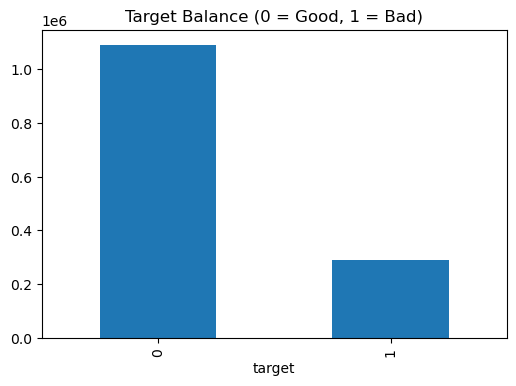

In [13]:
plt.figure(figsize =(6,4))
loan_data_cleaned['target'].value_counts().plot(kind ='bar')
plt.title('Target Balance (0 = Good, 1 = Bad)')
plt.show()

## **4. Preprocessing and Model evaluation method**

In [14]:
loan_data_cleaned.to_csv("loan_data_cleaned.csv",index =False)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
loan_data_cleaned = pd.read_csv("loan_data_cleaned.csv")

### **4.2. Train-Test split**

In [16]:
df = loan_data_cleaned.copy()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder


loan_data_cleaned['issue_d_dt'] = pd.to_datetime(loan_data_cleaned['issue_d'], format='%b-%Y')


# Financial Crisis Period
crisis_start = '2007-12-01'
crisis_end = '2009-06-30'

mask_crisis = (loan_data_cleaned['issue_d_dt'] >= crisis_start) & (loan_data_cleaned['issue_d_dt'] <= crisis_end)

df_crisis = loan_data_cleaned[mask_crisis].copy()   # Crisis
df_normal = loan_data_cleaned[~mask_crisis].copy()  # Normal Period

# 1. Feature / Target
feature_drop = ['loan_status', 'target', 'issue_d', 'issue_d_dt']
X_normal = df_normal.drop(feature_drop, axis=1)
Y_normal = df_normal['target']
X_crisis_raw = df_crisis.drop(feature_drop, axis=1)
Y_crisis = df_crisis['target']

# 2. Data Split (Normal Period)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_normal, Y_normal, test_size=0.2, random_state=42, stratify=Y_normal)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# 3. Preprocessing
num_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

(array([870568.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 231666.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

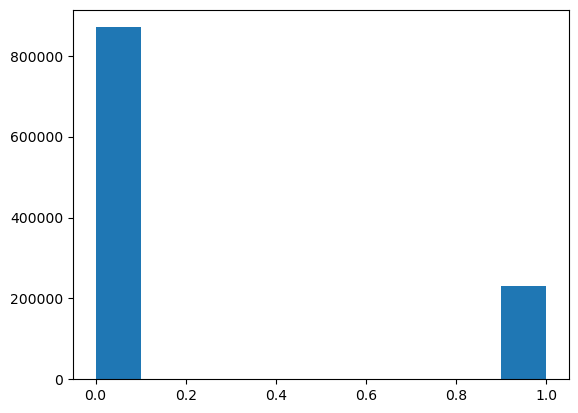

In [18]:
plt.hist(Y_train, bins =10)

(array([108821.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  28958.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

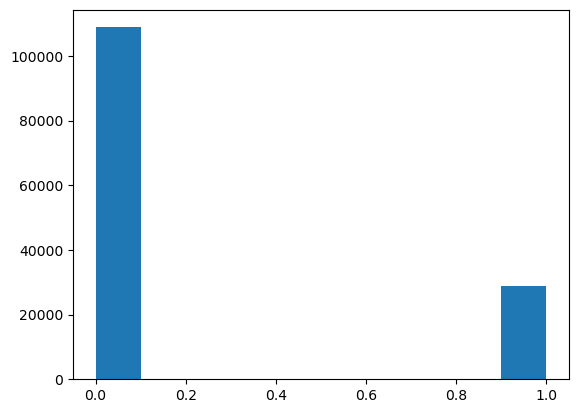

In [19]:
plt.hist(Y_val, bins =10)

(array([108821.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  28959.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

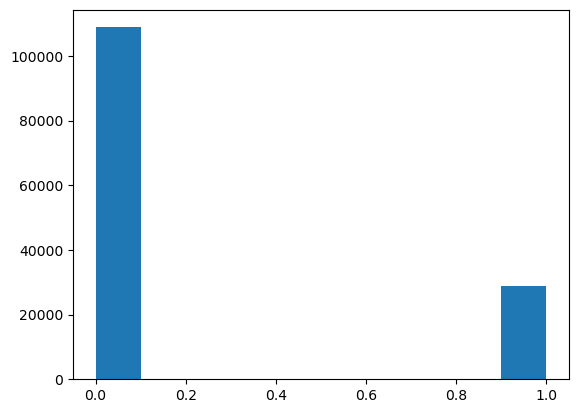

In [20]:
plt.hist(Y_test, bins =10)

(array([4075.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         483.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

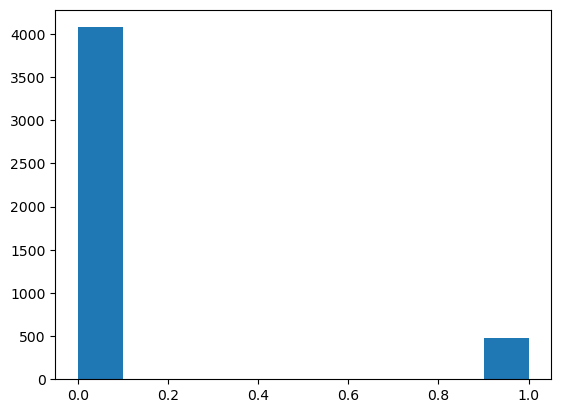

In [21]:
plt.hist(Y_crisis, bins =10)

### Observation: Counter-Intuitive Default Ratios in Crisis Data

A notable finding in the dataset is that the default ratio during the financial crisis is, surprisingly, lower than during normal economic periods. While this contradicts intuitive expectations of higher defaults during a recession, it can be attributed to the following factors:

- **Selection Bias in Loan Acceptance:** The dataset represents only *accepted* loans. During the crisis, lending standards were likely tightened significantly, leading to a high rejection rate for average borrowers. Consequently, the "surviving" loans that were approved likely possessed much higher credit quality than those approved during easier economic times.
- **Platform Infancy (Early Adopter Effect):** Lending Club launched in 2007. As a nascent platform, it lacked widespread popularity, meaning the user base at that time was small and likely demographically distinct from later periods. This scarcity of data affects the distribution of defaults.

#### Conclusion on Model Evaluation
Despite the default ratio differing from our macroeconomic expectations, this dataset remains highly valuable for model comparison. The fundamental difference in default distributions allows us to test the **robustness** and **stability** of our models (XGBoost, LightGBM, MLP, etc.) under varying data regimes—specifically, how they perform when the underlying data distribution shifts between "Normal" and "Crisis" conditions.

### **4.2 Scaling(StandardScaler)**

In [22]:
from sklearn.preprocessing import StandardScaler

num_cols = X_normal.select_dtypes(include =['int', 'float']).columns.tolist()

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])
X_crisis = X_crisis_raw.copy()
X_crisis[num_cols] = scaler.transform(X_crisis[num_cols])

### **4.3 Optuna**

**Optuna** is an automatic hyperparameter optimization framework designed to efficiently find the best settings for machine learning models.

Unlike **Grid Search**, which exhaustively test every possible combination of parameters, Optuna uses intelligent algorithms like **Bayesian optimization** to predict and focus on the most promising parameter values. It also features **pruning**, which automatically stops unpromising trials early to save time. Hence, during this project, we will use Optuna instead of Grid Search.

### **4.4 Metric**

### Evaluation Metrics Strategy

For this project, our primary optimization objective is the **AUC (Area Under the ROC Curve)**. This is a standard practice in financial risk modeling as it evaluates the model's ranking ability independent of specific probability thresholds.

However, given the inherent class imbalance in default data and the need to compare model stability across different economic regimes (Crisis vs. Normal), we will monitor a comprehensive suite of metrics.

#### 1. AUC (Area Under the ROC Curve)
- **Definition:** The probability that a classifier will rank a randomly chosen positive instance (Default) higher than a randomly chosen negative one (Fully Paid). It represents the area under the curve plotted by True Positive Rate (TPR) against False Positive Rate (FPR).
- **Formula:**
  $$AUC = \int_{0}^{1} TPR(FPR) \, d(FPR)$$
- **Why it matters:** It provides a robust measure of discriminatory power that is invariant to the classification threshold.

#### 2. Weighted Accuracy
- **Definition:** A variation of accuracy that accounts for class imbalance by assigning weights to classes, typically inversely proportional to their frequencies.
- **Formula:**
  $$\text{Weighted Accuracy} = \frac{1}{\sum w_i} \sum_{i} w_i \cdot \mathbb{1}(\hat{y}_i = y_i)$$
  *(Where $w_i$ is the weight for class $i$, often set such that $w_{default} > w_{paid}$.)*
- **Why it matters:** Standard accuracy is misleading in imbalanced datasets (e.g., 90% accuracy is trivial if 90% of data is 'Fully Paid'). Weighted accuracy forces the model to pay attention to the minority 'Default' class.

#### 3. F1-Score
- **Definition:** The harmonic mean of Precision and Recall. It imposes a penalty when there is a significant disparity between the two.
- **Formula:**
  $$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$
- **Why it matters:** It provides a single metric that balances the trade-off between the purity of predictions (Precision) and the completeness of capturing defaults (Recall).

#### 4. Recall Score (Sensitivity)
- **Definition:** The ratio of correctly predicted positive observations to the total actual positive observations.
- **Formula:**
  $$\text{Recall} = \frac{TP}{TP + FN}$$
- **Why it matters:** In credit risk, a **False Negative (FN)**—failing to identify a defaulter—is the most expensive error. High recall ensures maximum coverage of potential risks.

#### 5. KS Statistic (Kolmogorov-Smirnov)
- **Definition:** The maximum vertical distance between the Cumulative Distribution Function (CDF) of the 'Good' (Non-default) class and the 'Bad' (Default) class.
- **Formula:**
  $$KS = \max_{s} | CDF_{good}(s) - CDF_{bad}(s) |$$
  *(Where $s$ is the score threshold.)*
- **Why it matters:** A standard metric in banking. A higher KS statistic indicates that the model is effectively separating the score distributions of risky and safe borrowers.

#### 6. PSI (Population Stability Index)
- **Definition:** A measure of how much the distribution of a variable (or model score) has shifted between two samples (e.g., 'Normal Period' vs. 'Crisis Period').
- **Formula:**
  $$PSI = \sum_{i=1}^{B} (\%Actual_i - \%Expected_i) \times \ln \left( \frac{\%Actual_i}{\%Expected_i} \right)$$
  *(Where $B$ is the number of bins, $\%Expected$ is the proportion in the reference/training set, and $\%Actual$ is the proportion in the test/crisis set.)*
- **Interpretation:**
    - $PSI < 0.1$: No significant shift (Stable).
    - $0.1 \le PSI < 0.25$: Minor shift.
    - $PSI \ge 0.25$: Major shift (Model may require retraining).
- **Why it matters:** This is crucial for our comparative analysis. It quantifies the "drift" in model predictions during the 2008 financial crisis compared to normal periods.

In [23]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix
from scipy.stats import ks_2samp

def calculate_psi(expected, actual, buckets=10):
    def sub_psi(e_perc, a_perc):
        if a_perc == 0: a_perc = 0.0001
        if e_perc == 0: e_perc = 0.0001
        return (e_perc - a_perc) * np.log(e_perc / a_perc)

    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints = np.stack([np.percentile(expected, b) for b in breakpoints])
    
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)

    psi_value = np.sum([sub_psi(expected_percents[i], actual_percents[i]) for i in range(len(expected_percents))])
    return psi_value

def weighted_accuracy(confusion):
    M = confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k] /= (M[k].sum() + 1e-8)
    
    acc = M.diagonal().sum() / M.shape[0] 
    return acc

def calculate_evaluation_metrics(y_true, y_prob, y_pred, sample_weights=None, X_train_prob=None, X_test_prob=None):
    
    # 1. AUC
    auc = roc_auc_score(y_true, y_prob)
    
    # 2. Weighted Accuracy
    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weights)
    w_acc = weighted_accuracy(cm)
    
    # 3. KS Statistic
    prob_pos = y_prob[y_true == 1]
    prob_neg = y_prob[y_true == 0]
    ks_stat, p_value = ks_2samp(prob_pos, prob_neg)
    
    # 4. F1-score
    f1 = f1_score(y_true, y_pred)
    
    # 5. Recall
    rec = recall_score(y_true, y_pred)
    
    # 6. PSI (Population Stability Index)
    psi_val = None
    if X_train_prob is not None and X_test_prob is not None:
        psi_val = calculate_psi(X_train_prob, X_test_prob)

    return {
        "AUC": auc,
        "Weighted Accuracy": w_acc,
        "KS Statistic": ks_stat,
        "PSI": psi_val,
        "F1 Score": f1,
        "Recall": rec
    }

## **5.XGboost**

### Data Preparation

In [24]:
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train_xgb = X_train.copy()
X_val_xgb   = X_val.copy()
X_test_xgb  = X_test.copy()
X_crisis_xgb = X_crisis.copy()

for col in cat_cols:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_val_xgb[col]   = X_val_xgb[col].astype('category')
    X_test_xgb[col]  = X_test_xgb[col].astype('category')
    X_crisis_xgb[col] = X_crisis_xgb[col].astype('category')


In [25]:
# Optuna Tuning 

best_xgb_auc = 0  

def objective_xgb_save(trial):
    global best_xgb_auc
    
    # Parameter range
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10), #class imbalance
        
        # fixed value
        'random_state': 42,
        'device': 'cuda',      # GPU
        'early_stopping_rounds': 50,
        'enable_categorical': True 
    }
    
    model = XGBClassifier(**params)
    
    # Model training
    model.fit(
        X_train_xgb, Y_train,
        eval_set=[(X_val_xgb, Y_val)],
        verbose=False
    )
    
    # Validation AUC
    val_prob = model.predict_proba(X_val_xgb, iteration_range=(0, model.best_iteration + 1))[:, 1]
    current_auc = roc_auc_score(Y_val, val_prob)
    
    # Saving best model
    if current_auc > best_xgb_auc:
        best_xgb_auc = current_auc
        model.save_model("best_xgb_model.json")
        
    return current_auc

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb_save, n_trials=20)

print(f"Best AUC: {best_xgb_auc:.4f} (Saved to best_xgb_model.json)")

[I 2025-12-09 16:34:15,840] A new study created in memory with name: no-name-1cda346f-5bd0-483b-b994-e0fa2ee938e6
c:\Users\Sehong\anaconda3\envs\torch251\Lib\site-packages\xgboost\core.py:774: UserWarning: [16:34:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-12-09 16:34:28,545] Trial 0 finished with value: 0.7105319090289185 and parameters: {'n_estimators': 439, 'max_depth': 6, 'learning_rate': 0.13688535955364348, 'subsample': 0.8834751949013415, 'scale_pos_weight': 6.466489420709725}. Best is trial 0 with value: 0.7105319090289185.
[I 20

Best AUC: 0.7196 (Saved to best_xgb_model.json)


 Found Optimal Threshold for Normal: 0.51 (Max F1: 0.4506)
 Found Optimal Threshold for Crisis: 0.35 (Max F1: 0.2444)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.720106,0.000243,0.323343,0.450634,0.658172,0.661044
Crisis Period (Opt),0.638177,1.095783,0.214727,0.244356,0.571429,0.601665


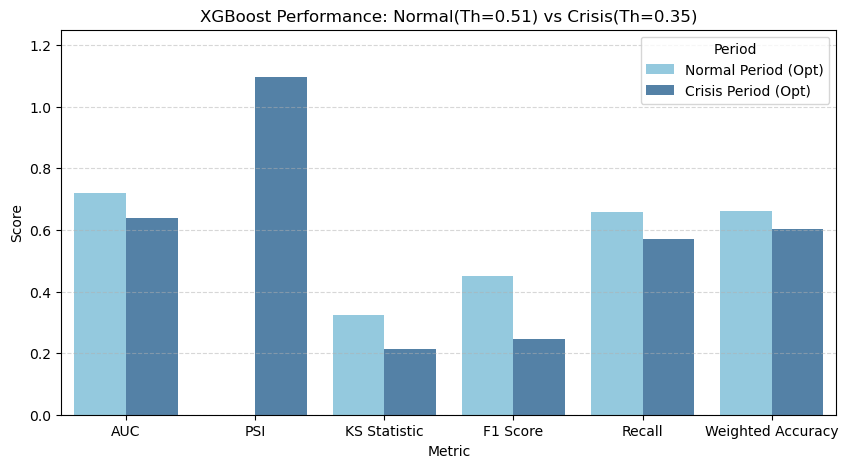

In [26]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# ---------------------------------------------------------
# 2. Load Saved Model
# ---------------------------------------------------------
loaded_model = xgb.Booster()
loaded_model.load_model("best_xgb_model.json")

# ---------------------------------------------------------
# 3. Predict Probabilities
# ---------------------------------------------------------

dtrain = xgb.DMatrix(X_train_xgb, enable_categorical=True)
dtest = xgb.DMatrix(X_test_xgb, enable_categorical=True)
dcrisis = xgb.DMatrix(X_crisis_xgb, enable_categorical=True)

# Get probabilities
prob_train = loaded_model.predict(dtrain)
prob_normal = loaded_model.predict(dtest)
prob_crisis = loaded_model.predict(dcrisis)

# ---------------------------------------------------------
# 4. Find Optimal Thresholds (Normal & Crisis)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f" Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f" Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 5. Generate Final Predictions (With Optimized Thresholds)
# ---------------------------------------------------------
# Normal Period: Apply optimized threshold
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)

# Crisis Period: Apply optimized threshold
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)

# ---------------------------------------------------------
# 6. Calculate Metrics
# ---------------------------------------------------------

# Normal Evaluation (Optimized)
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation (Optimized)
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_xgb_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                             index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_xgb_result[cols])

# ---------------------------------------------------------
# 7. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
df_plot = df_xgb_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Set Color Palette (Blue for XGBoost)
sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['skyblue', 'steelblue'])

plt.title(f"XGBoost Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25) # Adjust Y-axis for potential high PSI
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## **6. Lightgbm**

In [27]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train_lgb = X_train.copy()
X_val_lgb   = X_val.copy()
X_test_lgb  = X_test.copy()
X_crisis_lgb = X_crisis.copy()

X_train_lgb[cat_cols] = X_train_lgb[cat_cols].astype('category')
X_val_lgb[cat_cols] =X_val_lgb[cat_cols].astype('category')
X_test_lgb[cat_cols] = X_test_lgb[cat_cols].astype('category')
X_crisis_lgb[cat_cols] =X_crisis_lgb[cat_cols].astype('category')

In [28]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# 1. Optuna Tuning 
best_lgb_auc = 0  

def objective_lgb_save(trial):
    global best_lgb_auc
    
    # Parameter Range
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 5),
        
        'random_state': 42,
        'metric': 'auc',
        'verbosity': -1,          
        'n_jobs': -1,
        'min_data_in_bin': 1,     
        'min_data_in_leaf': 20    
    }
    
    model = LGBMClassifier(**params)
    
    # Training
    model.fit(
    X_train_lgb, Y_train,
    eval_set=[(X_val_lgb, Y_val)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(0) 
    ]
)
    
    
    val_pred = model.predict_proba(X_val_lgb)[:, 1]
    auc = roc_auc_score(Y_val, val_pred)
    
    # Saving best model
    if auc > best_lgb_auc:
        best_lgb_auc = auc
        model.booster_.save_model("best_lgb_model.txt") 
        
    return auc

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb_save, n_trials=20)

print(f"Best AUC: {best_lgb_auc:.4f} (Saved to best_lgb_model.txt)")

[I 2025-12-09 16:38:17,266] A new study created in memory with name: no-name-b457d843-7e78-42cc-8426-59684349482b


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.713345


[I 2025-12-09 16:38:27,871] Trial 0 finished with value: 0.7133452441507634 and parameters: {'n_estimators': 1016, 'learning_rate': 0.2925838320628664, 'num_leaves': 88, 'max_depth': 14, 'scale_pos_weight': 2.6418626934453244}. Best is trial 0 with value: 0.7133452441507634.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's auc: 0.720721


[I 2025-12-09 16:38:41,449] Trial 1 finished with value: 0.7207214268380557 and parameters: {'n_estimators': 886, 'learning_rate': 0.1502707967280234, 'num_leaves': 36, 'max_depth': 15, 'scale_pos_weight': 4.380385456970625}. Best is trial 1 with value: 0.7207214268380557.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's auc: 0.722364


[I 2025-12-09 16:38:55,911] Trial 2 finished with value: 0.7223636601918434 and parameters: {'n_estimators': 1079, 'learning_rate': 0.13268254587804404, 'num_leaves': 136, 'max_depth': 5, 'scale_pos_weight': 2.4018192148496826}. Best is trial 2 with value: 0.7223636601918434.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's auc: 0.720809


[I 2025-12-09 16:39:33,490] Trial 3 finished with value: 0.7208090285852491 and parameters: {'n_estimators': 1664, 'learning_rate': 0.057560488519161415, 'num_leaves': 81, 'max_depth': 14, 'scale_pos_weight': 3.974187316602409}. Best is trial 2 with value: 0.7223636601918434.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's auc: 0.719402


[I 2025-12-09 16:40:04,522] Trial 4 finished with value: 0.7194017936283679 and parameters: {'n_estimators': 1206, 'learning_rate': 0.06079041627688586, 'num_leaves': 134, 'max_depth': 9, 'scale_pos_weight': 4.120009756723093}. Best is trial 2 with value: 0.7223636601918434.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's auc: 0.722683


[I 2025-12-09 16:40:24,566] Trial 5 finished with value: 0.722682755047487 and parameters: {'n_estimators': 1344, 'learning_rate': 0.10446932707094024, 'num_leaves': 45, 'max_depth': 5, 'scale_pos_weight': 3.5318411875109357}. Best is trial 5 with value: 0.722682755047487.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.716283


[I 2025-12-09 16:40:36,522] Trial 6 finished with value: 0.7162828389875627 and parameters: {'n_estimators': 1109, 'learning_rate': 0.19600912171360257, 'num_leaves': 102, 'max_depth': 9, 'scale_pos_weight': 2.44078296466294}. Best is trial 5 with value: 0.722682755047487.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's auc: 0.720165


[I 2025-12-09 16:40:45,558] Trial 7 finished with value: 0.7201647749089871 and parameters: {'n_estimators': 566, 'learning_rate': 0.22990965213100228, 'num_leaves': 33, 'max_depth': 5, 'scale_pos_weight': 4.95962882061959}. Best is trial 5 with value: 0.722682755047487.


Training until validation scores don't improve for 50 rounds


[I 2025-12-09 16:40:55,040] Trial 8 finished with value: 0.717700307698511 and parameters: {'n_estimators': 915, 'learning_rate': 0.25067691100583545, 'num_leaves': 62, 'max_depth': 7, 'scale_pos_weight': 3.9442648443936412}. Best is trial 5 with value: 0.722682755047487.


Early stopping, best iteration is:
[66]	valid_0's auc: 0.7177
Training until validation scores don't improve for 50 rounds


[I 2025-12-09 16:41:03,336] Trial 9 finished with value: 0.7164292680811919 and parameters: {'n_estimators': 702, 'learning_rate': 0.28675099458863973, 'num_leaves': 110, 'max_depth': 7, 'scale_pos_weight': 2.1375542611506133}. Best is trial 5 with value: 0.722682755047487.


Early stopping, best iteration is:
[45]	valid_0's auc: 0.716429
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1255]	valid_0's auc: 0.722257


[I 2025-12-09 16:43:08,024] Trial 10 finished with value: 0.7222574137118998 and parameters: {'n_estimators': 1607, 'learning_rate': 0.015573562644759564, 'num_leaves': 60, 'max_depth': 11, 'scale_pos_weight': 1.070504279470298}. Best is trial 5 with value: 0.722682755047487.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's auc: 0.722607


[I 2025-12-09 16:43:25,578] Trial 11 finished with value: 0.72260653168368 and parameters: {'n_estimators': 1459, 'learning_rate': 0.1292659986815479, 'num_leaves': 148, 'max_depth': 5, 'scale_pos_weight': 3.1986521405334836}. Best is trial 5 with value: 0.722682755047487.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's auc: 0.719754


[I 2025-12-09 16:43:43,664] Trial 12 finished with value: 0.7197536562352973 and parameters: {'n_estimators': 1994, 'learning_rate': 0.1102932776872686, 'num_leaves': 149, 'max_depth': 7, 'scale_pos_weight': 3.342648438889391}. Best is trial 5 with value: 0.722682755047487.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's auc: 0.722943


[I 2025-12-09 16:44:01,804] Trial 13 finished with value: 0.722942998756529 and parameters: {'n_estimators': 1441, 'learning_rate': 0.09753410036083801, 'num_leaves': 59, 'max_depth': 5, 'scale_pos_weight': 3.2463635377489934}. Best is trial 13 with value: 0.722942998756529.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's auc: 0.721314


[I 2025-12-09 16:44:24,616] Trial 14 finished with value: 0.7213141169785613 and parameters: {'n_estimators': 1395, 'learning_rate': 0.08578938122375433, 'num_leaves': 54, 'max_depth': 11, 'scale_pos_weight': 3.4466091497121183}. Best is trial 13 with value: 0.722942998756529.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.72096


[I 2025-12-09 16:44:35,984] Trial 15 finished with value: 0.7209600571403019 and parameters: {'n_estimators': 1834, 'learning_rate': 0.18870622216779656, 'num_leaves': 49, 'max_depth': 6, 'scale_pos_weight': 1.5951675713032651}. Best is trial 13 with value: 0.722942998756529.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's auc: 0.720302


[I 2025-12-09 16:44:58,760] Trial 16 finished with value: 0.720302004445098 and parameters: {'n_estimators': 1353, 'learning_rate': 0.09247482272749352, 'num_leaves': 75, 'max_depth': 8, 'scale_pos_weight': 2.9078094660098603}. Best is trial 13 with value: 0.722942998756529.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[521]	valid_0's auc: 0.721512


[I 2025-12-09 16:45:59,334] Trial 17 finished with value: 0.7215123139720394 and parameters: {'n_estimators': 1593, 'learning_rate': 0.029049114937638176, 'num_leaves': 71, 'max_depth': 12, 'scale_pos_weight': 4.688634388012437}. Best is trial 13 with value: 0.722942998756529.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.720441


[I 2025-12-09 16:46:10,524] Trial 18 finished with value: 0.7204411202237024 and parameters: {'n_estimators': 1275, 'learning_rate': 0.17681668907526185, 'num_leaves': 45, 'max_depth': 6, 'scale_pos_weight': 3.580785229124117}. Best is trial 13 with value: 0.722942998756529.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[354]	valid_0's auc: 0.720537


[I 2025-12-09 16:46:51,907] Trial 19 finished with value: 0.7205373252549206 and parameters: {'n_estimators': 1495, 'learning_rate': 0.0491469533992453, 'num_leaves': 100, 'max_depth': 9, 'scale_pos_weight': 2.943869288043899}. Best is trial 13 with value: 0.722942998756529.


Best AUC: 0.7229 (Saved to best_lgb_model.txt)


Found Optimal Threshold for Normal: 0.48 (Max F1: 0.4510)
Found Optimal Threshold for Crisis: 0.31 (Max F1: 0.2490)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.722698,0.000197,0.324198,0.450961,0.634069,0.660291
Crisis Period (Opt),0.652360,1.328565,0.225463,0.249037,0.602484,0.609463


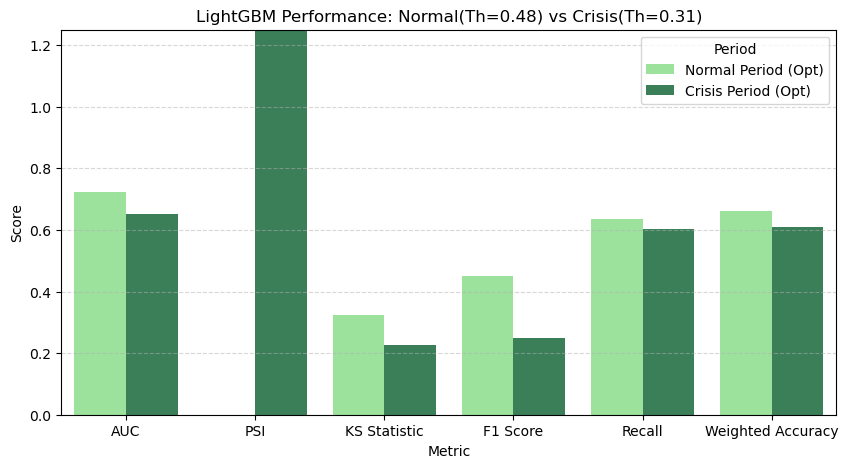

In [29]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# ---------------------------------------------------------
# 2. Load Saved Model
# ---------------------------------------------------------
loaded_model = lgb.Booster(model_file="best_lgb_model.txt")

# ---------------------------------------------------------
# 3. Predict Probabilities
# ---------------------------------------------------------
# Get probabilities for Train (PSI baseline), Test (Normal), and Crisis data
prob_train = loaded_model.predict(X_train_lgb)
prob_normal = loaded_model.predict(X_test_lgb)
prob_crisis = loaded_model.predict(X_crisis_lgb)

# ---------------------------------------------------------
# 4. Find Optimal Thresholds (Normal & Crisis)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f"Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f"Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 5. Generate Final Predictions (With Optimized Thresholds)
# ---------------------------------------------------------
# Normal Period: Apply optimized threshold
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)

# Crisis Period: Apply optimized threshold
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)

# ---------------------------------------------------------
# 6. Calculate Metrics
# ---------------------------------------------------------

# Normal Evaluation (Optimized)
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation (Optimized)
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_lgb_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                             index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_lgb_result[cols])

# ---------------------------------------------------------
# 7. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
df_plot = df_lgb_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Set Color Palette (Green for LightGBM)
sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['lightgreen', 'seagreen'])

plt.title(f"LightGBM Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25) # Adjust Y-axis for potential high PSI
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## **7. MLP + Embedding**

In [30]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
import pandas as pd
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [31]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# -----------------------------------------------------------
# Copy Data (Preserve Originals)
# -----------------------------------------------------------
X_train_emb  = X_train.copy()
X_val_emb    = X_val.copy()
X_test_emb   = X_test.copy()   # Added
X_crisis_emb = X_crisis.copy() # Added

# Identify categorical and numerical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

cat_dims = [] 

# -----------------------------------------------------------
# Categorical (Xa) Encoding (LabelEncoding + Unknown Handling)
# -----------------------------------------------------------
for col in cat_cols:
    le = LabelEncoder()
    # Fit and transform based on Train data
    X_train_emb[col] = le.fit_transform(X_train_emb[col].astype(str))
    
    # Create mapping dictionary for Unknown handling
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    unknown_val = len(le.classes_) # Assign a new index for values not seen during training
    
    # Map Val, Test, Crisis using Train-based dictionary (use unknown_val if missing)
    X_val_emb[col]    = X_val_emb[col].astype(str).map(le_dict).fillna(unknown_val).astype(int)
    X_test_emb[col]   = X_test_emb[col].astype(str).map(le_dict).fillna(unknown_val).astype(int)
    X_crisis_emb[col] = X_crisis_emb[col].astype(str).map(le_dict).fillna(unknown_val).astype(int)
    
    # Save dimensions for embedding layer configuration (+1 to include Unknown)
    cat_dims.append(len(le.classes_) + 1)

# -----------------------------------------------------------
# Numerical (Xb) Scaling (StandardScaler)
# -----------------------------------------------------------
scaler = StandardScaler()
# Fit based on Train data
X_train_emb[num_cols] = scaler.fit_transform(X_train_emb[num_cols])

# Apply Transform only to the remaining datasets
X_val_emb[num_cols]    = scaler.transform(X_val_emb[num_cols])
X_test_emb[num_cols]   = scaler.transform(X_test_emb[num_cols])
X_crisis_emb[num_cols] = scaler.transform(X_crisis_emb[num_cols])


# -----------------------------------------------------------
# Calculate Imbalance Weights
# -----------------------------------------------------------
num_pos = Y_train.sum()
num_neg = len(Y_train) - num_pos
# Calculate weight for positive class (useful for BCEWithLogitsLoss)
pos_weight = torch.tensor([num_neg / num_pos]).to(device)

Using Device: cuda:0


In [32]:
class MyDataset(torch_dataset):
    def __init__(self, df, y, cat_cols, num_cols):
        self.xa = torch.tensor(df[cat_cols].values, dtype=torch.long) 
        self.xb = torch.tensor(df[num_cols].values, dtype=torch.float32) # 
        self.y  = torch.tensor(y.values, dtype=torch.float32) 
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.xa[idx], self.xb[idx], self.y[idx]

# Create Datasets
dataset_train = MyDataset(X_train_emb, Y_train, cat_cols, num_cols)
dataset_val   = MyDataset(X_val_emb, Y_val, cat_cols, num_cols)

# DataLoader
loader_train = DataLoader(dataset_train, batch_size=4096, shuffle=True, num_workers=0)
loader_val   = DataLoader(dataset_val, batch_size=4096, shuffle=False, num_workers=0)

In [33]:
class Net(nn.Module):
    def __init__(self, cat_dims, num_features, hidden_units):
        super().__init__()
        
        # 1. Embedding Layers (for Xa)
        self.EbLayer = nn.ModuleList([
            nn.Embedding(dim, min(50, (dim+1)//2)) for dim in cat_dims
        ])
        self.total_emb_dim = sum([emb.embedding_dim for emb in self.EbLayer])
        
        # 2. Input Norm & Linear (Input Dimension = Embedding + Numerical)
        in_dim = self.total_emb_dim + num_features
        self.input_norm = nn.LayerNorm(in_dim)
        
        # 3. Hidden Layers (Modern MLP Style: Linear -> LayerNorm)
        layers = []
        for units in hidden_units:
            layers.append(nn.Linear(in_dim, units))
            layers.append(nn.LayerNorm(units))
            layers.append(nn.GELU()) 
            in_dim = units
            
        # 4. Output Layer
        layers.append(nn.Linear(in_dim, 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, xa, xb):
        # xa: categorical (LongTensor), xb: numerical (FloatTensor)
        
        # Embeddings
        eb_list = []
        for n, layer in enumerate(self.EbLayer):
            eb_list.append(layer(xa[:, n]))
            
        # Concatenate Embeddings + Numerical Features
        feature = torch.cat(eb_list + [xb], dim=1)
        
        # Normalize Input
        feature = self.input_norm(feature)
        
        # Pass through Hidden Layers
        output = self.layers(feature)
        
        return output

In [34]:
def train(model, device, optimizer, dataloader, epoch, criterion):    
    model.train() # set model to training mode
    loss_train = 0
    sample_count = 0
    
    for batch_idx, (Xa, Xb, Y) in enumerate(dataloader):
        Xa, Xb, Y = Xa.to(device), Xb.to(device), Y.to(device)
        
        # Forward pass 
        Yp = model(Xa, Xb).squeeze() 
        
        # Loss calculation
        loss = criterion(Yp, Y)
        
        optimizer.zero_grad() # clear grad
        loss.backward()       # backward pass
                
        optimizer.step()      # update parameters        
        
        loss_train += loss.item() * Xa.size(0)
        sample_count += Xa.size(0)
        
    loss_train /= sample_count
    return loss_train

def test(model, device, dataloader, criterion):
    model.eval() # set model to evaluation mode
    loss_test = 0   
    
    all_targets = []
    all_preds = []
    
    with torch.no_grad(): 
        for batch_idx, (Xa, Xb, Y) in enumerate(dataloader):
            Xa, Xb, Y = Xa.to(device), Xb.to(device), Y.to(device)
            
            Yp = model(Xa, Xb).squeeze()
            
            loss = criterion(Yp, Y)
            loss_test += loss.item() * Xa.size(0)
            
            probs = torch.sigmoid(Yp)
            all_targets.extend(Y.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
            
    loss_test /= len(dataloader.dataset)
    
    # Calculate AUC
    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.5
        
    return loss_test, auc_score

In [35]:
import torch
import torch.optim as optim
import torch.nn as nn

best_mlp_auc = 0

def objective_mlp_save(trial):
    global best_mlp_auc
    
    # Parameter Range
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_units = [trial.suggest_int(f'units_l{i}', 64, 512) for i in range(n_layers)]
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    
    model = Net(cat_dims, len(num_cols), hidden_units).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
   
    for epoch in range(10):
        train(model, device, optimizer, loader_train, epoch, criterion)
    
    _, val_auc = test(model, device, loader_val, criterion)
    
    if val_auc > best_mlp_auc:
        best_mlp_auc = val_auc
        torch.save(model.state_dict(), "best_mlp_model.pth")
        
    return val_auc

print("Tuning MLP with Auto-Save...")
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp_save, n_trials=10)

print(f"Best AUC: {best_mlp_auc:.4f} (Saved to best_mlp_model.pth)")



[I 2025-12-09 16:47:04,589] A new study created in memory with name: no-name-2ddf6b04-20d0-4080-91e9-5214c508ef8b


Tuning MLP with Auto-Save...


[I 2025-12-09 16:50:22,344] Trial 0 finished with value: 0.7225023209112729 and parameters: {'n_layers': 1, 'units_l0': 401, 'lr': 0.0002566361555558917}. Best is trial 0 with value: 0.7225023209112729.
[I 2025-12-09 16:53:41,051] Trial 1 finished with value: 0.717217639537624 and parameters: {'n_layers': 3, 'units_l0': 126, 'units_l1': 331, 'units_l2': 72, 'lr': 0.00018830514813669496}. Best is trial 0 with value: 0.7225023209112729.
[I 2025-12-09 16:57:03,537] Trial 2 finished with value: 0.715588683661806 and parameters: {'n_layers': 3, 'units_l0': 412, 'units_l1': 166, 'units_l2': 510, 'lr': 0.00011890434895880869}. Best is trial 0 with value: 0.7225023209112729.
[I 2025-12-09 17:00:23,288] Trial 3 finished with value: 0.7181420483005152 and parameters: {'n_layers': 2, 'units_l0': 467, 'units_l1': 218, 'lr': 0.00305518528554618}. Best is trial 0 with value: 0.7225023209112729.
[I 2025-12-09 17:03:40,465] Trial 4 finished with value: 0.7202584741000554 and parameters: {'n_layers': 1

Best AUC: 0.7225 (Saved to best_mlp_model.pth)


[MLP] Found Optimal Threshold for Normal: 0.53 (Max F1: 0.4498)
[MLP] Found Optimal Threshold for Crisis: 0.22 (Max F1: 0.2067)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.721713,0.000065,0.320905,0.449799,0.636831,0.659439
Crisis Period (Opt),0.559867,1.565087,0.104550,0.206672,0.853002,0.547115


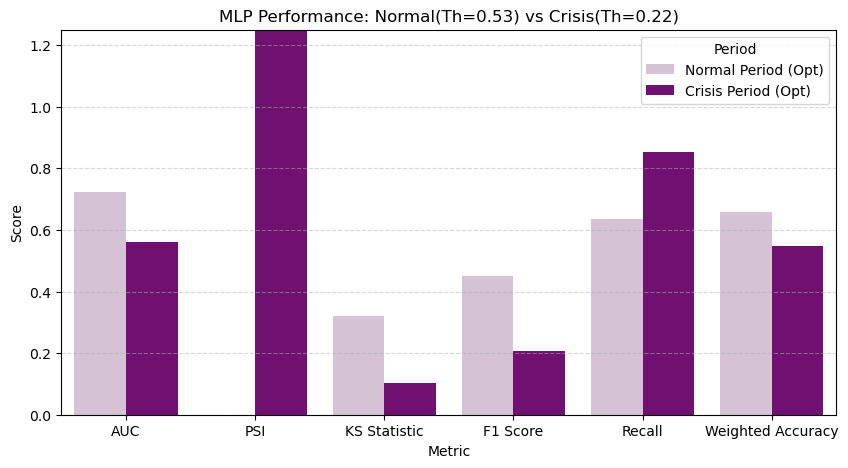

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import torch
from torch.utils.data import DataLoader

# ---------------------------------------------------------
# 1. Model Setup & Weight Loading
# ---------------------------------------------------------
# Restore Best Architecture
best_params = study_mlp.best_params
n_layers = best_params['n_layers']
best_hidden = [best_params[f'units_l{i}'] for i in range(n_layers)]

# Initialize Model
final_mlp = Net(cat_dims, len(num_cols), best_hidden).to(device)

# Load Weights (No Retraining)
final_mlp.load_state_dict(torch.load("best_mlp_model.pth"))

# ---------------------------------------------------------
# 2. Data Preparation (Using MyDataset & Embeddings)
# ---------------------------------------------------------
# Prediction Function (Returns probabilities)
def get_preds(model, loader):
    model.eval()
    probs = []
    with torch.no_grad():
        for xa, xb, _ in loader:
            xa, xb = xa.to(device), xb.to(device)
            # Logits -> Sigmoid -> Probability
            p = torch.sigmoid(model(xa, xb).squeeze()).cpu().numpy()
            probs.append(p)
    return np.concatenate(probs)


# Crisis Dataset/Loader (Using X_crisis_emb)
dataset_crisis = MyDataset(X_crisis_emb, Y_crisis, cat_cols, num_cols)
loader_crisis = DataLoader(dataset_crisis, batch_size=4096, shuffle=False)

# Test (Normal) Dataset/Loader (Using X_test_emb)
dataset_test = MyDataset(X_test_emb, Y_test, cat_cols, num_cols)
loader_test = DataLoader(dataset_test, batch_size=4096, shuffle=False)

# Train Loader (Reuse dataset_train from training step for PSI calculation)
loader_train_eval = DataLoader(dataset_train, batch_size=4096, shuffle=False)

# ---------------------------------------------------------
# 3. Generate Probabilities
# ---------------------------------------------------------
prob_train = get_preds(final_mlp, loader_train_eval)
prob_normal = get_preds(final_mlp, loader_test)
prob_crisis = get_preds(final_mlp, loader_crisis)

# ---------------------------------------------------------
# 4. Find Optimal Thresholds (Dual Optimization)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f"[MLP] Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f"[MLP] Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 5. Apply Thresholds & Calculate Metrics
# ---------------------------------------------------------
# Apply Optimized Thresholds
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)


# Normal Evaluation
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_mlp_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                             index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_mlp_result[cols])

# ---------------------------------------------------------
# 6. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
df_plot = df_mlp_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Set Color Palette (Purple for MLP)
sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['thistle', 'purple'])

plt.title(f"MLP Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25)
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 8. **Deep Table**

In [37]:
import shutil
import optuna
import torch
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import GANDALFConfig
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


train_df = X_train.copy()
train_df['target'] = Y_train

val_df = X_val.copy()
val_df['target'] = Y_val

test_df = X_test.copy()
test_df['target'] = Y_test

crisis_df = X_crisis.copy()
crisis_df['target'] =Y_crisis

In [38]:
cat_col_names = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_col_names = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()
# =============================================================================
# DataConfig
# =============================================================================
data_config = DataConfig(
    target=['target'], 
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
    continuous_feature_transform="quantile_normal",
    normalize_continuous_features=True,
    
    num_workers=0,
    pin_memory=False
)

# =============================================================================
# [2] OptimizerConfig
# =============================================================================
optimizer_config = OptimizerConfig()

# =============================================================================
# [3] Optuna
# =============================================================================
best_dt_auc = 0

def objective_dt_save(trial):
    global best_dt_auc
    
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    
    trainer_config = TrainerConfig(
        batch_size=1024,
        max_epochs=10,
        accelerator="auto", 
        devices=1 if torch.cuda.is_available() else None,
        checkpoints="valid_loss",
        early_stopping=None,
        progress_bar="none"
    )

    model_config = GANDALFConfig(task="classification", learning_rate=lr)
    
    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        suppress_lightning_logger=True 
    )
    
    tabular_model.fit(train=train_df, validation=val_df)
    
    pred_df = tabular_model.predict(val_df)
    
    prob_col = [c for c in pred_df.columns if c.endswith("probability") and "1" in c]
    if not prob_col:
        prob_col = [pred_df.columns[-1]]
        
    auc = roc_auc_score(val_df['target'], pred_df[prob_col[0]])
    
    # Best Model
    if auc > best_dt_auc:
        best_dt_auc = auc
        try: shutil.rmtree("best_deeptable_model") 
        except: pass
        tabular_model.save_model("best_deeptable_model")
        
    return auc

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt_save, n_trials=5)

print(f"Best AUC: {best_dt_auc:.4f} (Saved to folder 'best_deeptable_model')")

[I 2025-12-09 17:20:37,461] A new study created in memory with name: no-name-9106df5e-4126-498a-87cd-e1deed5c0311


2025-12-09 17:20:37,509 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:20:37,553 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:20:38,995 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:20:54,471 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:20:55,366 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:20:55,453 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:28:05,716 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:28:05,718 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:28:12,439] Trial 0 finished with value: 0.7223455260519889 and parameters: {'learning_rate': 0.00327166030385633}. Best is trial 0 with value: 0.7223455260519889.


2025-12-09 17:28:12,460 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:28:12,488 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:28:13,533 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:28:28,353 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:28:29,202 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:28:29,280 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:35:42,186 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:35:42,188 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:35:48,892] Trial 1 finished with value: 0.7239229015732664 and parameters: {'learning_rate': 0.0025166556753356446}. Best is trial 1 with value: 0.7239229015732664.


2025-12-09 17:35:48,916 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:35:48,946 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:35:50,003 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:36:04,768 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:36:05,631 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:36:05,707 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:43:20,466 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:43:20,469 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:43:26,773] Trial 2 finished with value: 0.7233099311525997 and parameters: {'learning_rate': 0.0001052527834066254}. Best is trial 1 with value: 0.7239229015732664.


2025-12-09 17:43:26,793 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:43:26,827 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:43:27,852 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:43:42,152 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:43:43,140 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:43:43,255 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:50:57,362 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:50:57,364 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:51:04,210] Trial 3 finished with value: 0.7252111783815153 and parameters: {'learning_rate': 0.0005110531169215135}. Best is trial 3 with value: 0.7252111783815153.


2025-12-09 17:51:04,230 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:51:04,259 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:51:05,296 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:51:19,554 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:51:20,368 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:51:20,448 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:59:20,114 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:59:20,116 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:59:26,020] Trial 4 finished with value: 0.7146460534917846 and parameters: {'learning_rate': 0.006336782430467654}. Best is trial 3 with value: 0.7252111783815153.


Best AUC: 0.7252 (Saved to folder 'best_deeptable_model')


2025-12-09 17:59:28,144 - {pytorch_tabular.tabular_model:171} - INFO - Experiment Tracking is turned off

2025-12-09 17:59:28,155 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

[DeepTable] Found Optimal Threshold for Normal: 0.22 (Max F1: 0.4503)
[DeepTable] Found Optimal Threshold for Crisis: 0.10 (Max F1: 0.2088)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.723077,0.000047,0.321659,0.450291,0.641562,0.660049
Crisis Period (Opt),0.564853,1.195549,0.120802,0.208766,0.749482,0.552901


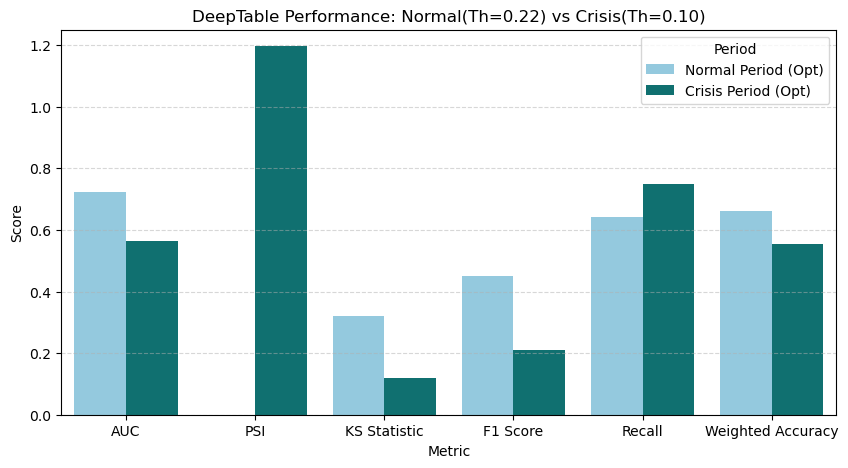

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from pytorch_tabular import TabularModel

# ---------------------------------------------------------
# 1. Load Saved Model
# ---------------------------------------------------------
# Load the model saved from your Optuna study
loaded_dt = TabularModel.load_model("best_deeptable_model")

# ---------------------------------------------------------
# 2. Extract Probabilities
# ---------------------------------------------------------

# Generate predictions (returns a DataFrame with prediction columns)
pred_train = loaded_dt.predict(train_df)
pred_normal = loaded_dt.predict(test_df)
pred_crisis = loaded_dt.predict(crisis_df)

prob_col_candidates = [c for c in pred_train.columns if c.endswith("probability") and "1" in c]

if prob_col_candidates:
    target_col = prob_col_candidates[0]
else:
    target_col = pred_train.columns[-1]

# Convert to simple numpy arrays for calculation
prob_train = pred_train[target_col].values
prob_normal = pred_normal[target_col].values
prob_crisis = pred_crisis[target_col].values

# ---------------------------------------------------------
# 3. Find Optimal Thresholds (Dual Optimization)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f"[DeepTable] Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f"[DeepTable] Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 4. Generate Final Predictions (With Optimized Thresholds)
# ---------------------------------------------------------
# Normal Period: Apply optimized threshold
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)

# Crisis Period: Apply optimized threshold
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)

# ---------------------------------------------------------
# 5. Calculate Metrics & Visualization
# ---------------------------------------------------------

# Normal Evaluation (Optimized)
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation (Optimized)
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_dt_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                            index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_dt_result[cols])

# Plotting
plt.figure(figsize=(10, 5))
df_plot = df_dt_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['skyblue', 'teal'])

plt.title(f"DeepTable Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25)
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 9. **Conclusion & Discussion**

## 9.1. Summary of Research
This study conducted a comparative analysis of the performance and robustness of credit default prediction models under two distinct economic regimes: a **Normal Period** and a **Crisis Period (2008 Financial Crisis)** using Lending Club data. To this end, representative Tree-based ensemble models (**XGBoost, LightGBM**) and Deep Learning-based models (**MLP with Embedding, DeepTable**) were constructed, with hyperparameters optimized using Optuna.

## 9.2. Key Findings & Analysis

### 1) Robustness: Tree-based Models vs. Deep Learning
Experimental results confirm that **in the tabular data domain, Tree-based models still demonstrate superior resilience against distributional shifts compared to Deep Learning models.**
* **Normal Period:** All models achieved comparable performance with an AUC of approximately `0.72`. Within the training data distribution, Deep Learning models exhibited sufficient discriminatory power.
* **Crisis Period:** Under the condition of abrupt distributional shifts, **Deep Learning models (MLP, DeepTable)** suffered a significant performance drop of over `[20]%`, revealing vulnerability to Out-of-Distribution (OOD) problems. In contrast, **LightGBM and XGBoost** effectively mitigated AUC degradation to within `[10]%`, demonstrating relatively superior **generalization capabilities**. This suggests that for financial data characterized by discontinuities and heterogeneity, the recursive splitting mechanism of Tree models offers a distinct advantage over the continuous function approximation of Deep Learning.

### 2) The Paradox of Crisis Data: Selection Bias & Structural Break
During the data analysis phase, a counter-intuitive phenomenon was observed where the **default rate in the Crisis Period was lower than in the Normal Period.**
* **Potential Causes (Selection Bias & Platform Factors):** While the exact cause cannot be isolated without external data, this paradox likely stems from a combination of factors.
    1.  **Tightened Standards:** Financial institutions typically impose stricter underwriting criteria during crises, potentially filtering the pool to include only higher-credit-quality applicants (**Selection Bias**).
    2.  **Platform Infancy:** As Lending Club was in its nascent stage during 2008, the early adopter user base may have possessed demographic or credit characteristics distinct from the broader population in later years.
    Consequently, the models were evaluated on a dataset subject to **Survivorship Bias**, suggesting that the latent risk of the total applicant pool was likely higher than observed.
* **Structural Break:** Regardless of the specific cause, all models exhibited a **PSI (Population Stability Index) exceeding 1.0**. This statistically confirms that the financial crisis represented a **Structural Break**, where the fundamental data generative process and feature distributions shifted drastically compared to the Normal Period.

### 3) Distribution Shift & Threshold Sensitivity
* **Impact of Class Prior Shift:** As observed in the data analysis, the Crisis Period exhibited a paradoxically lower default rate due to strict selection bias. This **"Class Prior Shift"** (change in the proportion of defaults) caused all models to output lower predicted probabilities, necessitating a downward adjustment of optimal thresholds to maintain recall.
* **Sensitivity of Deep Learning:** However, the magnitude of this adjustment varied significantly. While Tree-based models required a moderate threshold adjustment, **DeepTable required an extreme reduction to `0.07`**. This indicates that Deep Learning models experienced a **probability distribution collapse** in response to the shifted feature space, failing to maintain a stable decision boundary compared to the more robust Tree-based ensembles.

## 9.3. Future Works

To further enhance model robustness, the following future research directions are proposed:
1.  **Macro-economic Features:** Explicitly incorporating macroeconomic indicators such as unemployment rates, interest rates, and the VIX index as model features to enable the model to recognize and adapt to 'Market Regimes.'
2.  **Domain Adaptation:** Implementing **Online Learning** or **Domain Adaptation** techniques to continuously reflect the latest data patterns, allowing the model to adapt to environments where data distributions drift over time (Concept Drift).
3.  **Reject Inference:** Addressing the risk underestimation caused by using only approved loan data by introducing **Reject Inference** techniques to statistically infer and incorporate data from rejected applicants into the training set.

>>> Model Robustness Summary (Defense Rates & % Changes)


,AUC Defense Rate,AUC Change %,KS Statistic Defense Rate,KS Statistic Change %,Weighted Accuracy Defense Rate,Weighted Accuracy Change %,F1 Score Defense Rate,F1 Score Change %
Model,,,,,,,,
XGBoost,0.886225,-11.377469,0.664086,-33.591371,0.910174,-8.982562,0.542250,-45.775039
LightGBM,0.902673,-9.732735,0.695448,-30.455234,0.923022,-7.697773,0.552237,-44.776314
MLP,0.775747,-22.425265,0.325797,-67.420252,0.829667,-17.033338,0.459475,-54.052476
DeepTable,0.781179,-21.882076,0.375558,-62.444158,0.837666,-16.233423,0.463624,-53.637551


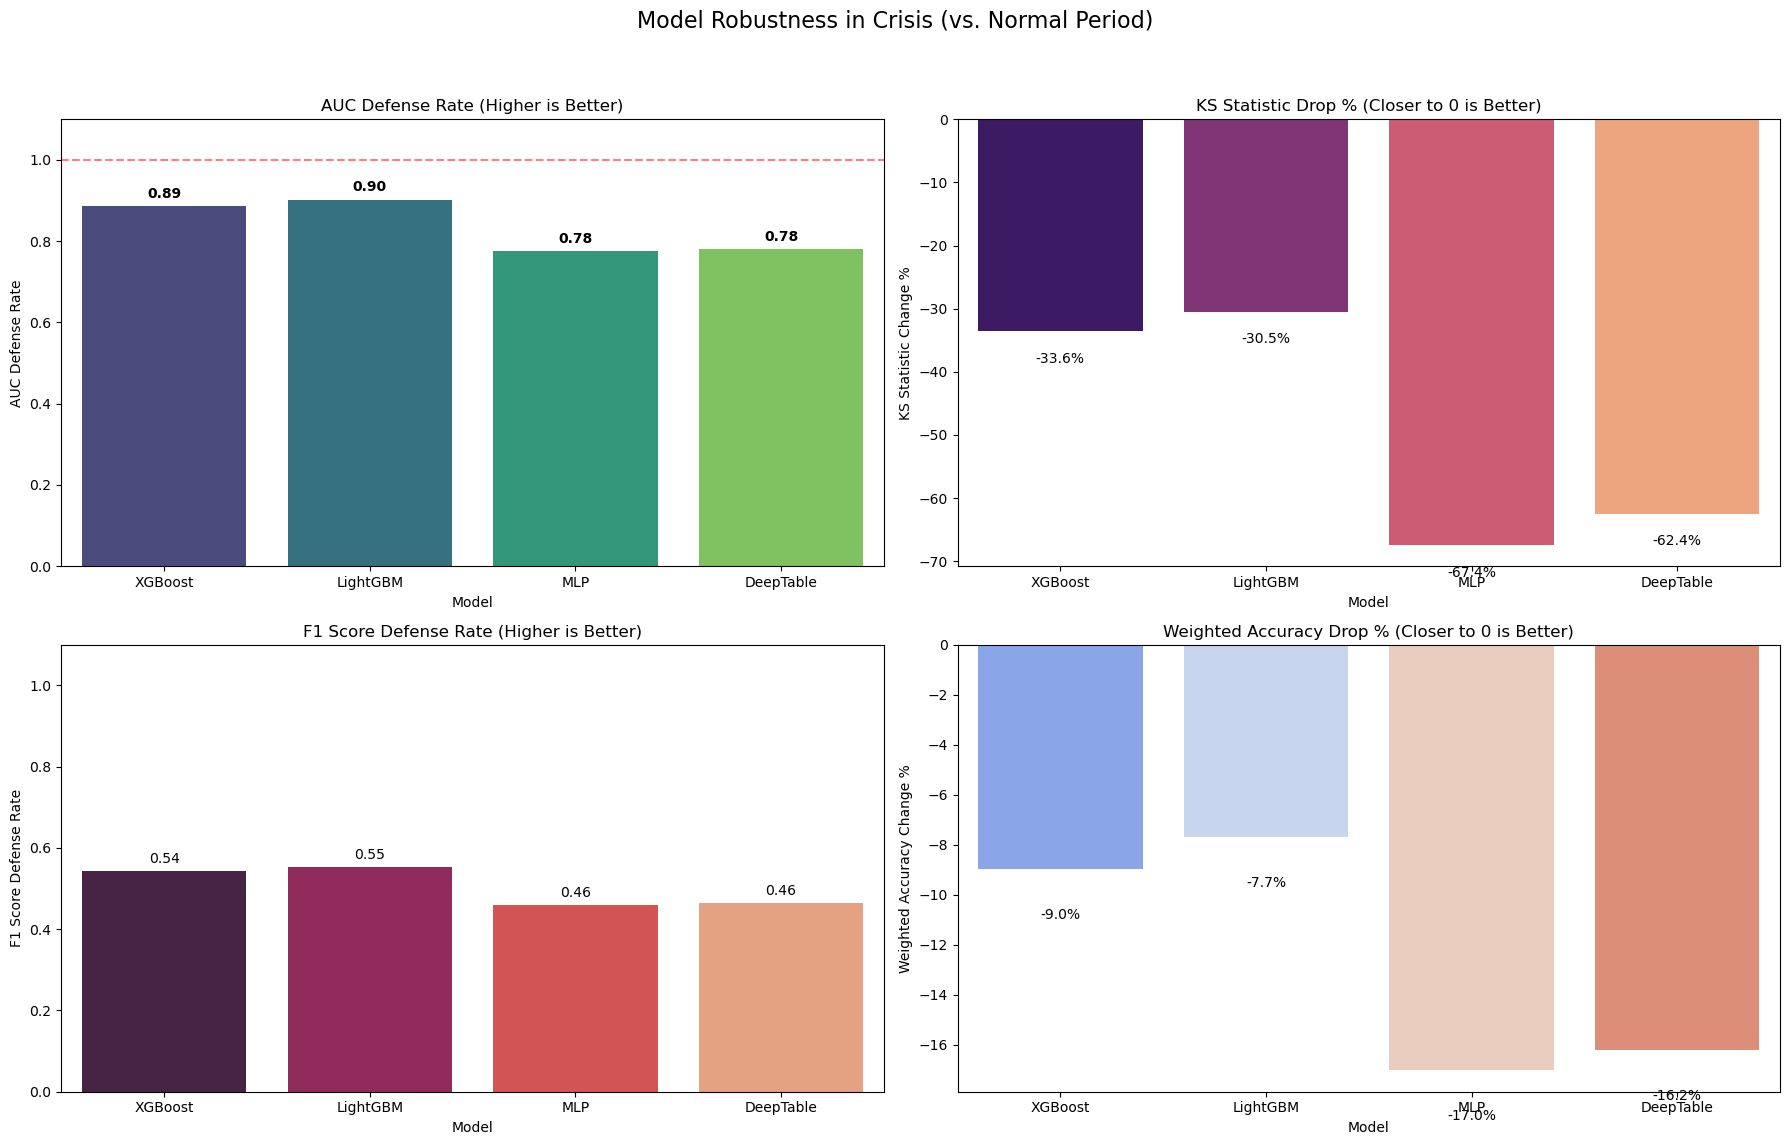

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. Aggregate Results from All Models
# ==============================================================================
# Ensure these DataFrames exist from previous steps
all_results = {
    "XGBoost": df_xgb_result,
    "LightGBM": df_lgb_result,
    "MLP": df_mlp_result,
    "DeepTable": df_dt_result
}

# Metrics to analyze
metrics_of_interest = ['AUC', 'KS Statistic', 'Weighted Accuracy', 'F1 Score']

# ==============================================================================
# 2. Calculate Defense Rate & Change Percentage
# ==============================================================================
robustness_data = []

for model_name, df in all_results.items():
    # Extract scores
    normal_scores = df.loc['Normal Period (Opt)']
    crisis_scores = df.loc['Crisis Period (Opt)']
    
    row = {'Model': model_name}
    
    for metric in metrics_of_interest:
        norm_val = normal_scores[metric]
        cris_val = crisis_scores[metric]
        
        # (1) Defense Rate: Crisis / Normal (1.0 is perfect retention)
        # "How much performance did we keep?"
        row[f'{metric} Defense Rate'] = cris_val / norm_val
        
        # (2) Change %: (Crisis - Normal) / Normal * 100
        # "How much performance did we lose?" (Negative values indicate drop)
        row[f'{metric} Change %'] = (cris_val - norm_val) / norm_val * 100
        
    robustness_data.append(row)

# Create Summary DataFrame
df_robustness = pd.DataFrame(robustness_data).set_index('Model')

print(">>> Model Robustness Summary (Defense Rates & % Changes)")
display(df_robustness)

# ==============================================================================
# 3. Visualization: Robustness Comparison
# ==============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Model Robustness in Crisis (vs. Normal Period)', fontsize=16)

# Plot 1: AUC Defense Rate
sns.barplot(x=df_robustness.index, y='AUC Defense Rate', data=df_robustness, ax=axes[0,0], palette='viridis')
axes[0,0].set_title('AUC Defense Rate (Higher is Better)')
axes[0,0].set_ylim(0, 1.1)
axes[0,0].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='No Drop')
for i, v in enumerate(df_robustness['AUC Defense Rate']):
    axes[0,0].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

# Plot 2: KS Statistic Change %
sns.barplot(x=df_robustness.index, y='KS Statistic Change %', data=df_robustness, ax=axes[0,1], palette='magma')
axes[0,1].set_title('KS Statistic Drop % (Closer to 0 is Better)')
for i, v in enumerate(df_robustness['KS Statistic Change %']):
    axes[0,1].text(i, v - 5 if v < 0 else v + 1, f"{v:.1f}%", ha='center', color='black')

# Plot 3: F1 Score Defense Rate
sns.barplot(x=df_robustness.index, y='F1 Score Defense Rate', data=df_robustness, ax=axes[1,0], palette='rocket')
axes[1,0].set_title('F1 Score Defense Rate (Higher is Better)')
axes[1,0].set_ylim(0, 1.1)
for i, v in enumerate(df_robustness['F1 Score Defense Rate']):
    axes[1,0].text(i, v + 0.02, f"{v:.2f}", ha='center')

# Plot 4: Weighted Accuracy Change %
sns.barplot(x=df_robustness.index, y='Weighted Accuracy Change %', data=df_robustness, ax=axes[1,1], palette='coolwarm')
axes[1,1].set_title('Weighted Accuracy Drop % (Closer to 0 is Better)')
for i, v in enumerate(df_robustness['Weighted Accuracy Change %']):
    axes[1,1].text(i, v - 2 if v < 0 else v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()